# Vector Field Demo

## Setup
Install necessary libraries, if necessary

In [ ]:
!pip install gsw lic
!pip install "git+https://github.com/bhatiaharsh/naturalHHD.git@master#egg=pynhhd&subdirectory=pynhhd-v1.1"
!pip install POT


## Start Here

In [1]:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from pynhhd import nHHD
from vfield_util import vfield_vis,vfield_util


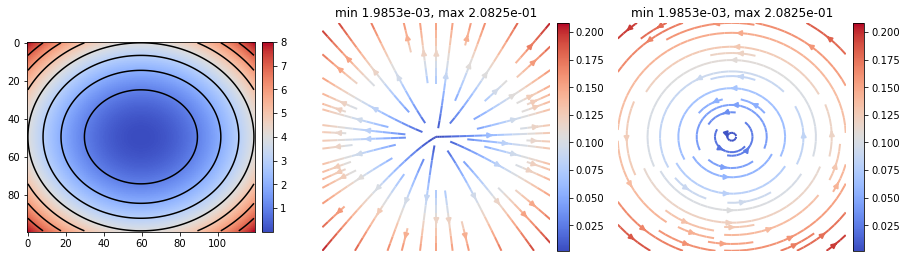

In [2]:
# Gradient and hamiltonian flow from a potential function

# set up domain
nx,ny = 120,100  # resolution
M = 2.0  #  the domain will be the square [-M,M]^2
dx = (2.0*M/ny, 2.0*M/nx)
X, Y = np.meshgrid(np.linspace(-M,M,nx),np.linspace(-M,M,ny))

# potential function
H=X**2+Y**2
# vector fields
gradV = vfield_util.grad(H) # gradient-flow
curlV = vfield_util.rot_grad(H) # curl-flow

# visualisation
fig, axs = plt.subplots(1,3, figsize=(15,5))
vfield_vis.plot_contour(H,ax=axs[0],levels=7)
vfield_vis.plot_slines(gradV[:,:,0],gradV[:,:,1],X=X,Y=Y,ax=axs[1])
vfield_vis.plot_slines(curlV[:,:,0],curlV[:,:,1],X=X,Y=Y,ax=axs[2])


vf = (100, 120), 0.021220263575870663, 7.280109889280518


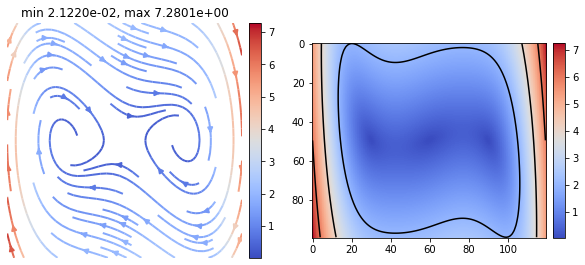

In [3]:
# define sample vector field

nx,ny = 120,100  # resolution
M = 2.0  #  the domain will be the square [-M,M]^2
dx = (2.0*M/ny, 2.0*M/nx)
X, Y = np.meshgrid(np.linspace(-M,M,nx),np.linspace(-M,M,ny))

# "duffing"
delta=0.5
alpha=1
beta=-1
vx = Y
vy  = -delta*Y-X*(beta+alpha*X**2)
vfield = np.stack([vx,vy],axis=-1)

## 
mvf = np.linalg.norm(vfield, axis=2)
print('vf = {}, {}, {}'.format(mvf.shape, mvf.min(), mvf.max()))

fig, axs = plt.subplots(1,2, figsize=(10,5))
vfield_vis.plot_slines(vfield[:,:,0],vfield[:,:,1],X=X,Y=Y,ax=axs[0])
vfield_vis.plot_contour(mvf,ax=axs[1])

generate lics: 100%|██████████| 15/15 [00:00<00:00, 203.02it/s]


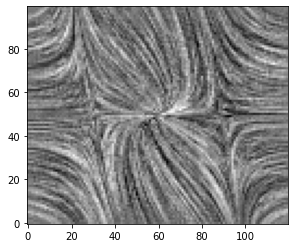

In [4]:
# visualisation by line integral convolution
import lic
plt.imshow(lic.lic(vfield[:,:,0],vfield[:,:,1], length=30), origin='lower', cmap='gray')


## Hodge decomposition

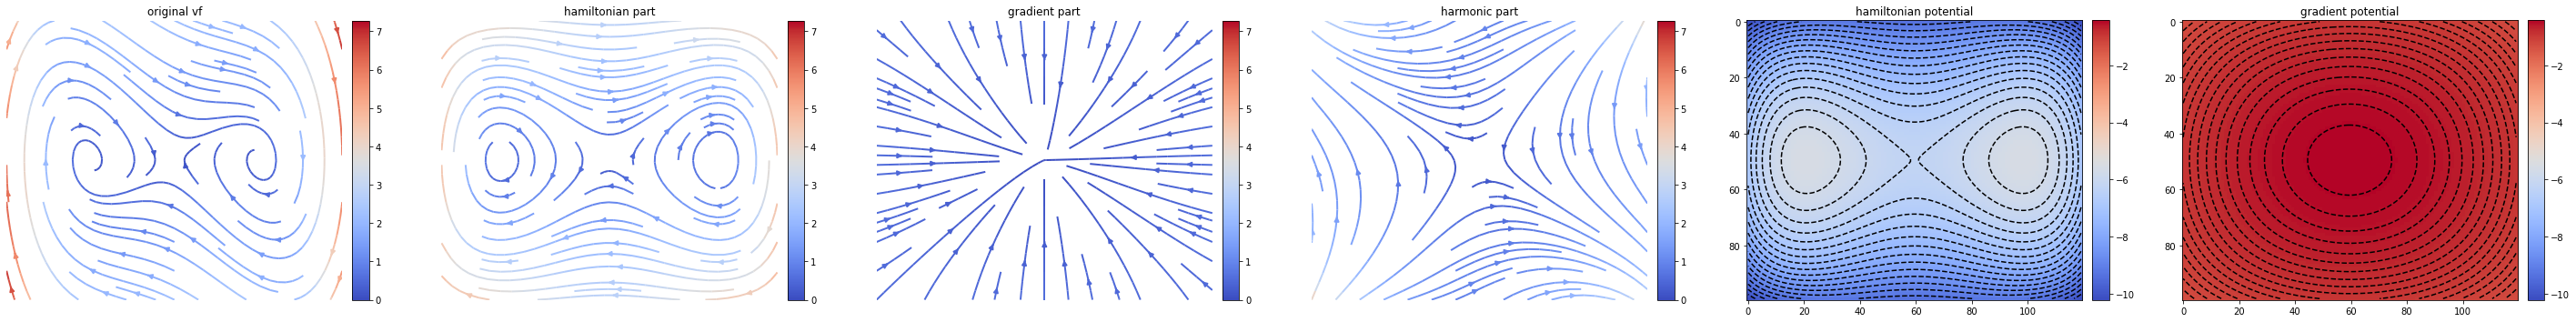

In [5]:
HHD_method = "nHHD"
#HHD_method = "FFT"

if HHD_method == "nHHD":
    # perform  natural HHD
    nhhd = nHHD(grid=vfield.shape[:2], spacings=dx)
    nhhd.decompose(vfield)
    mr = np.linalg.norm(nhhd.r, axis=2)
    md = np.linalg.norm(nhhd.d, axis=2)
    mh = np.linalg.norm(nhhd.h, axis=2)
    rf,df,hf = nhhd.r, nhhd.d, nhhd.h
    H,F = nhhd.nRu, nhhd.nD
else:
    # FFT-based HHD
    rf,df,H,F = vfield_util.decomp(vfield)
    hf = np.zeros_like(rf)+0.0001

# for colouring
potential_colour_norm = mpl.colors.Normalize(vmin=min(H.min(),F.min()),vmax=max(H.max(),F.max()))
vf_colour_norm = mpl.colors.Normalize(vmin=0, vmax=mvf.max())

# plot
fig,axs = plt.subplots(1,6,figsize=(50,8))
vfield_vis.plot_slines(vfield[:,:,0],vfield[:,:,1],ax=axs[0],norm=vf_colour_norm,title="original vf")
vfield_vis.plot_slines(rf[:,:,0],rf[:,:,1],ax=axs[1],norm=vf_colour_norm,title="hamiltonian part")
vfield_vis.plot_slines(df[:,:,0],df[:,:,1],ax=axs[2],norm=vf_colour_norm,title="gradient part")
vfield_vis.plot_slines(hf[:,:,0],hf[:,:,1],ax=axs[3],norm=vf_colour_norm,title="harmonic part")
vfield_vis.plot_contour(H,levels=20,ax=axs[4],norm=potential_colour_norm,title="hamiltonian potential")
vfield_vis.plot_contour(F,levels=20,ax=axs[5],norm=potential_colour_norm,title="gradient potential")


## Vector field interpolation
RBF interpolation of sparse observations

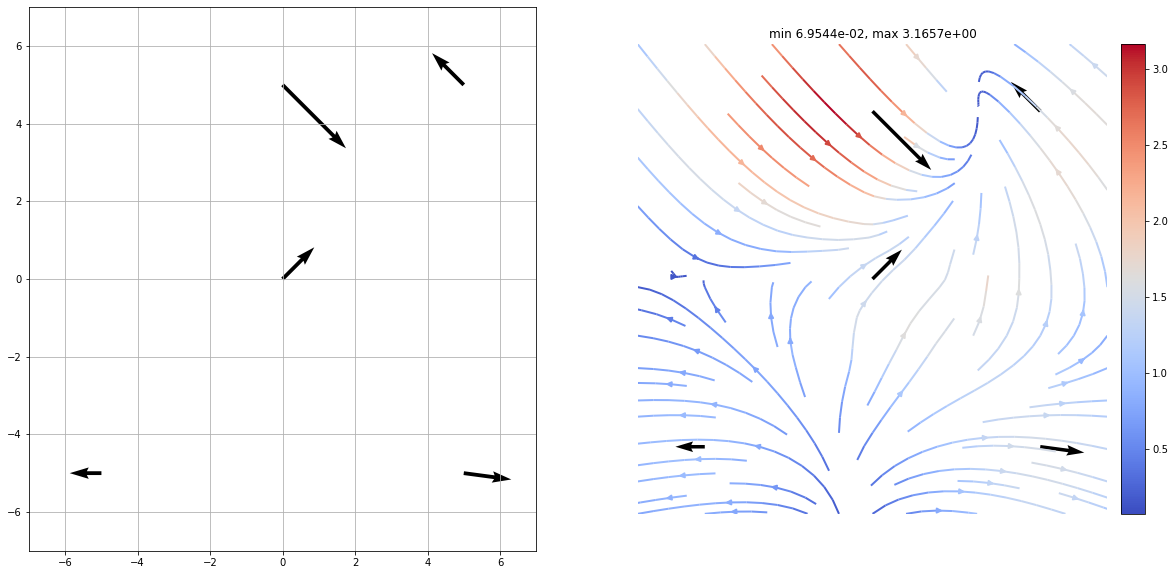

In [7]:
## Reconstruction from a sparse observation

X=[0,0,5,-5,5]
Y=[0,5,5,-5,-5]
u=np.array([1,2,-1,-1,1.5])
v=np.array([1,-2,1,0,-0.2])

f = vfield_util.interpolate_vfield(X,Y,u,v,NX=3,NY=3,neighbours=5,sigma=20)
# resample 
M=7
NX,NY=40,40
sX, sY = np.meshgrid(np.linspace(-M,M,NX),np.linspace(-M,M,NY))
svx,svy = vfield_util.sampling(sX,sY,f)

fig, axs=plt.subplots(1,2,figsize=(20,10))
vfield_vis.plot_slines(svx,svy,X=sX,Y=sY,ax=axs[1])
axs[1].quiver(X, Y, u, v,scale=16)
axs[1].grid()
axs[0].quiver(X, Y, u, v,scale=16)
axs[0].set_xlim(-M,M)
axs[0].set_ylim(-M,M)
axs[0].grid()



## Monge Optimal transport as vector field

Correspondence vector field from two sets of points. Similar to PIV or optical flow.

solving marginal #0


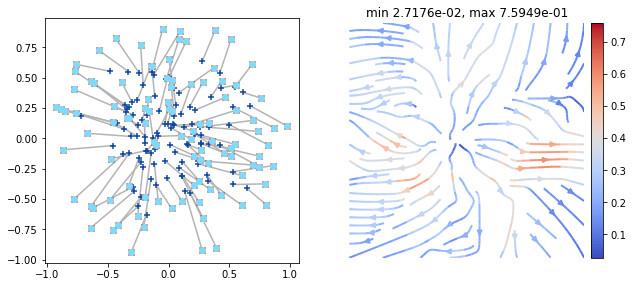

In [12]:

import matplotlib.collections as mc
from pyvot import vot_numpy, utils
np.random.seed(0)


## Two synthetic point clouds
N0, K = 100, 100
source_pts = np.random.multivariate_normal(mean=[0, 0], cov= [[.08, 0], [0, .08]], size=K).clip(-0.99, 0.99)
source_pts_org = source_pts.copy()
target_pts, _ = utils.random_sample(N0, 2, sampling='disk')

## compute monge's optimal transport
vot = vot_numpy.VOT(y=source_pts, x=target_pts, verbose=False)
output = vot.cluster(max_iter_y=1, max_iter_h=3000, lr=1, lr_decay=200, beta=0.9)

## plot OT correspondence
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].add_collection(mc.LineCollection(np.stack([source_pts, vot.y],axis=1), colors=utils.COLOR_LIGHT_GREY))
axs[0].scatter(source_pts_org[:, 0], source_pts_org[:, 1], marker='+', color=utils.COLOR_DARK_BLUE, zorder=2)
axs[0].scatter(target_pts[:, 0], target_pts[:, 1], marker='o', color=utils.COLOR_LIGHT_BLUE, zorder=4)
axs[0].scatter(vot.y[:, 0], vot.y[:, 1], marker='x', color=utils.COLOR_RED, zorder=3) # after transportation
#axs[4].scatter(vot.x[0][:, 0], vot.x[0][:, 1], marker='x', color=utils.COLOR_LIGHT_RED, zorder=1) # target
axs[0].set_aspect(1)

## interpolate OT map to obtain a vector field
vf = vot.y - source_pts
f = vfield_util.interpolate_vfield(source_pts[:,0],source_pts[:,1],vf[:,0],vf[:,1],NX=6,NY=6,neighbours=5)
M=1
NX,NY=40,40
sX, sY = np.meshgrid(np.linspace(-M,M,NX),np.linspace(-M,M,NY))
svx,svy = vfield_util.sampling(sX,sY,f)
vfield_vis.plot_slines(svx,svy,X=sX, Y=sY, ax=axs[1])



## Hamiltonian Neural Network
Neural Network で Hamiltonian を推定．スパースな観測，障害物の境界条件など，柔軟に対応可能．GPU がないと非常に時間がかかる．

In [13]:
from vfield_util import vfield_hnn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


boundary 60, region 360


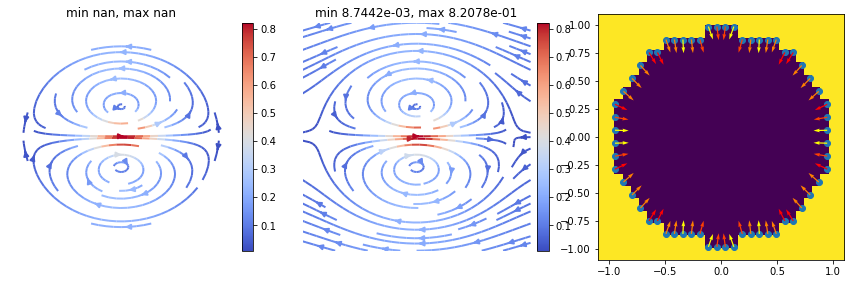

In [14]:
# create a sample hamiltonian field
nx,ny = 30j,20j
r = 1
a = 1
w,h = 1.1,1.1
epsilon = 1e-1
Y,X = np.mgrid[-h:h:ny,-w:w:nx]
# define obstacle
mask = np.zeros(X.shape,dtype=bool)
mask[X*X + a*Y*Y >= r**2] = 1
#mask[Y<-2]=1  ## half-plane
#H=X*X+(Y-s)*(Y-s)
H=Y*(1-1/(X**2+Y**2+epsilon))
dH = vfield_util.rot_grad(H)
dH_on = dH.copy()
dH_on[mask]=np.nan
#dH_on = np.ma.array(dH, mask = ~mask)
vx_org,vy_org = dH[:,:,0],dH[:,:,1]
vx,vy = dH_on[:,:,0],dH_on[:,:,1]
vfield = np.stack([vx,vy],axis=-1)    

# detect boundary
bd_idx,bd_vx,bd_vy = vfield_hnn.boundary_normal(~mask,sigma=1)
print(f"boundary {len(bd_idx)}, region {(~mask).sum()}")

# plot detected boundary condition
fig,axs = plt.subplots(1,3, figsize=(15,5))
axs[2].imshow(mask,vmax=1,origin='lower',extent=(-w,w,-h,h))
if len(bd_idx)>0:
    axs[2].scatter(X[bd_idx[:,1],bd_idx[:,0]],Y[bd_idx[:,1],bd_idx[:,0]])
    axs[2].quiver(X[bd_idx[:,1],bd_idx[:,0]],Y[bd_idx[:,1],bd_idx[:,0]],bd_vx,bd_vy,bd_vx**2+bd_vy**2,pivot='tail',cmap=plt.cm.autumn,scale_units='width',width=0.005)
    axs[2].set_aspect('equal')

## plot
vfield_vis.plot_slines(vx,vy,X,Y,ax=axs[0])
vfield_vis.plot_slines(vx_org,vy_org,X,Y,ax=axs[1])


In [5]:
#cx, cy = np.indices(H.shape)
epochs = 5000
if len(bd_idx)>0: # if there is boundary
    bd_X, bd_Y = X[bd_idx[:,1],bd_idx[:,0]],Y[bd_idx[:,1],bd_idx[:,0]]
else:
    bd_X, bd_Y = bd_vx, bd_vy
model = vfield_hnn.fit_HNN(X[~mask],Y[~mask],vx[~mask],vy[~mask],bd_X,bd_Y,bd_vx,bd_vy,epochs = epochs,batch_size=None,lr = 1e-3,lambda_boundary = 1.0, device=device)

#boundary pts 60, #region pts 360
iter 0, loss 0.1947854459285736, boundary loss 0.16573390364646912
iter 500, loss 0.022579781711101532, boundary loss 0.001901542185805738
iter 1000, loss 0.02341131865978241, boundary loss 0.0044389935210347176
iter 1500, loss 0.019652489572763443, boundary loss 0.0023373859003186226
iter 2000, loss 0.02080516144633293, boundary loss 0.002606623340398073
iter 2500, loss 0.02117999456822872, boundary loss 0.0017072305781766772
iter 3000, loss 0.022501446306705475, boundary loss 0.004368978552520275
iter 3500, loss 0.02159031853079796, boundary loss 0.001647944562137127
iter 4000, loss 0.022078994661569595, boundary loss 0.0026062633842229843
iter 4500, loss 0.02327384613454342, boundary loss 0.0010272895451635122


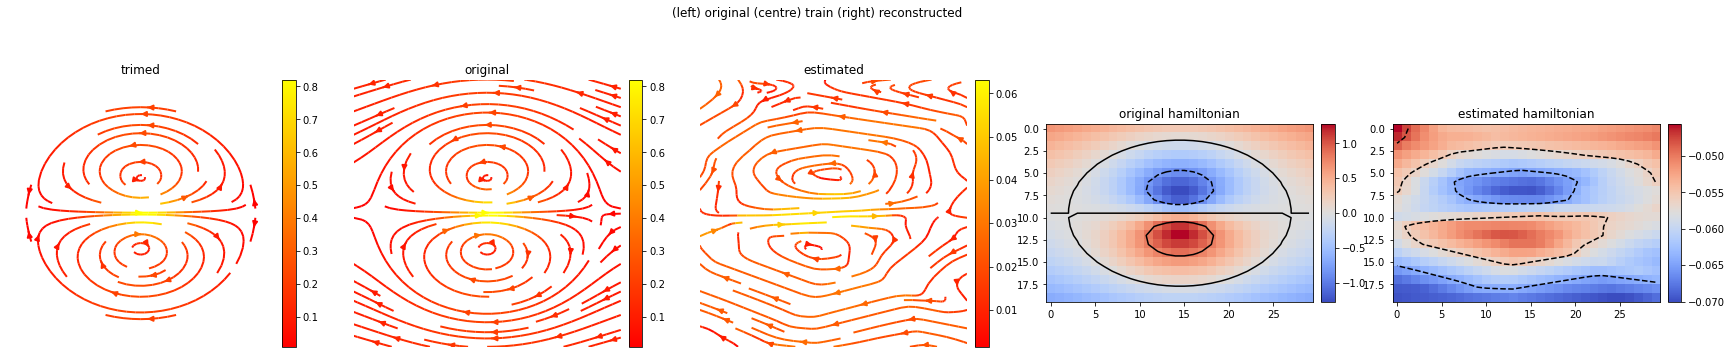

In [7]:
# reconstructed vfield
all_x = torch.tensor( np.stack([X,Y],axis=-1), requires_grad=True, dtype=torch.float32).to(device)
# reconstruct vector field
v_estimated=model.vfield(all_x).detach().cpu().numpy().reshape(vfield.shape)
# reconstruct hamiltonian
H_estimated=model(all_x).detach().cpu().numpy().reshape(H.shape)

# plot
fig, axs = plt.subplots(1, 5,figsize=(30,6))
fig.suptitle('(left) original (centre) train (right) reconstructed')
vfield_vis.plot_slines(vx,vy,X,Y,ax=axs[0],title="trimed")
vfield_vis.plot_slines(vx_org,vy_org,X,Y,ax=axs[1],title="original")
vfield_vis.plot_slines(v_estimated[:,:,0],v_estimated[:,:,1],X,Y,ax=axs[2],title="estimated")
vfield_vis.plot_contour(H,ax=axs[3],title="original hamiltonian")
vfield_vis.plot_contour(H_estimated,ax=axs[4],title="estimated hamiltonian")


## Koopman eigen functions
Dynamic mode decomposition (DMD)

In [15]:
from vfield_util import vfield_koopman
import scipy as sp

Eigensolver couldn't find solutions. Reverting to the norma equation for the zero eigenfunction


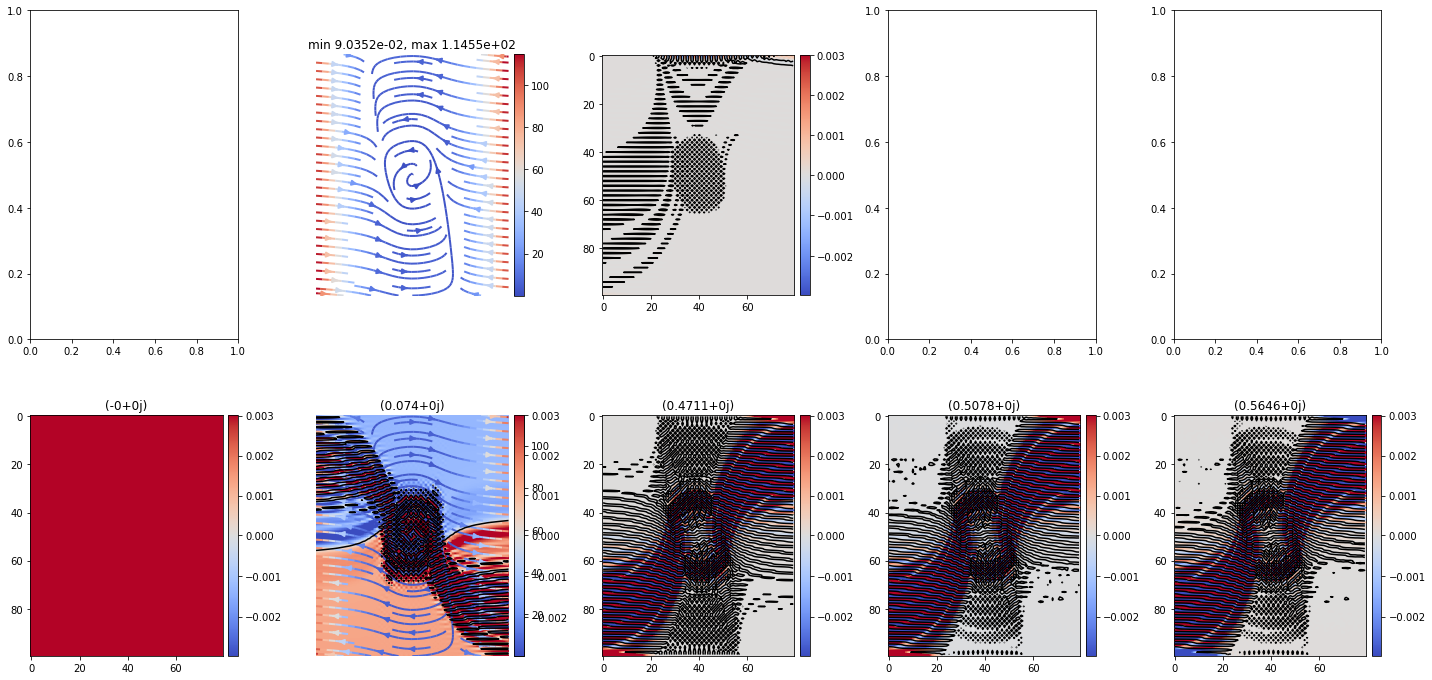

In [21]:

# define vector field
ny,nx = 100,80  # resolution
M = 7.0 
dx = (2.0*M/ny, 2.0*M/nx)
mu = 1
X, Y = np.meshgrid(np.linspace(-M,M,nx),np.linspace(-M,M,ny))
vx = mu*(X-(X**3)/3-Y)
vy = X/mu
vmg = np.sqrt(vx**2+vy**2)

# plot eigen functions
k = 5 # number modes to plot
fig, axs=plt.subplots(2,k,figsize=(20,10))
#vfield_vis.plot_contour(vmg, ax=axs[0,0], title="magnitude of v.f.")    

# search eigenvalues around
sigma = 0.01

# reduce data by thresholding
eps = 1e-2
idx = vmg.ravel()>eps

divnorm = mpl.colors.TwoSlopeNorm(vcenter=0)
#print(idx.sum(), nx*ny)
for sig in [0,1]: ## positive and negative
    vfield_vis.plot_slines((-1)**sig*vx,(-1)**sig*vy,ax=axs[sig,1])
    G = vfield_koopman.koopman_Lab((-1)**sig*vx,(-1)**sig*vy,dx,_a=10,_b=3)
    G = G[np.ix_(idx,idx)]
    try: # compute k smallest eigen values and functions
      w, phis = sp.sparse.linalg.eigs(G, k=k, which='SI', sigma=sigma, tol=1e-2, maxiter=5000)    # 'SI' for real eig vals
      for i in range(k):
        phi = np.zeros(ny*nx)
        phi[idx] = phis[:,i].real
        phi = phi.reshape(ny,nx)
        vfield_vis.plot_contour(phi, ax=axs[sig,i], title=str(np.round(w[i],4)), levels=[0], norm=divnorm)
    except: # solve only for zero eigenfunctions
      print("Eigensolver couldn't find solutions. Reverting to the norma equation for the zero eigenfunction")
      b=np.zeros(G.shape[0]) # zero eigen vector
      b[-1]=1 ## enforce phi[0] = 1 (killing ambiguity by a scalar multiple)
      phi = np.zeros(ny*nx)
      phi[idx] = sp.sparse.linalg.spsolve(G.T.dot(G),G.T.dot(b))  
      phi = phi.reshape(ny,nx)
      vfield_vis.plot_contour(phi, ax=axs[sig,2], levels=[0], norm=divnorm)      
fig.tight_layout()



In [19]:
## Mask to make it vanish at the boundary (make it a Dirichlet problem)

## search singular points
max_sing = 1
sing_pts = [np.argmin(vmg)]
for p in np.argsort(vmg.ravel()): # from smallest values
    sx, sy = np.unravel_index(p, vmg.shape)
    min_d = np.inf
    for spt in sing_pts:
        ssx, ssy = np.unravel_index(spt, vmg.shape)
        min_d = min(min_d,np.sqrt((sx-ssx)**2+(sy-ssy)**2)) ## distance from the nearest sing point
    if min_d>30 and mask[sx,sy]>0.1: # if enough isolated
        sing_pts.append(p)
    if len(sing_pts) >= max_sing:
        break

## Note: it may be better to use FEM (such as FEnicS to find the 0-eigen function. However, choosing an optimal boundary condition is a problem.)
mask = np.clip(0.9-np.sqrt(X**2+Y**2)/M,0,None)

vx *= mask
vy *= mask
                
print("indices of sing pts", sing_pts)


indices of sing pts [3959]


[0.         0.         0.99999999]


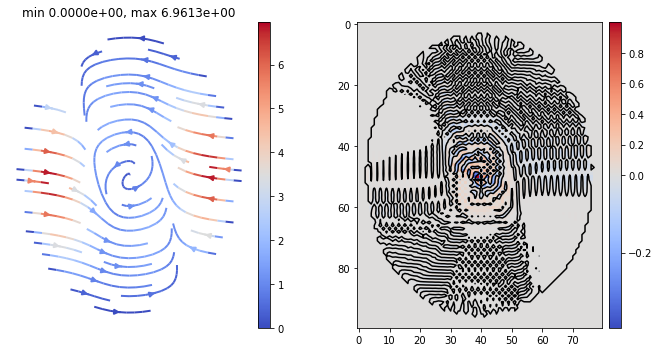

In [20]:
## plot a 0-eigen function having specific values at specified locations

from scipy.sparse.linalg import lsqr

# parameters
constraint_idx = [0,-1]+sing_pts  # indices of phi whose values are constrained
constraint_weight = 10000 # weight for the value constraints for phi
#constraint_val = [(i+1)*constraint_weight for i in range(len(constraint_idx))] # values of constrained points
constraint_val = [0,0] + [1]*len(sing_pts) # values of constrained points

fig, axs=plt.subplots(1,2,figsize=(10,5))
vfield_vis.plot_slines(vx,vy,ax=axs[0])

## plot location of constraint pts
# sing_loc = np.zeros_like(vmg)
# sing_loc.ravel()[constraint_idx] = 100
# plt.imshow(sing_loc)

# set up the linear operator L
G = vfield_koopman.koopman_Lab(vx,vy,dx,_a=10,_b=3, constraint_idx=constraint_idx, constraint_weight=constraint_weight)
#G = koopman_L(vx,vy,dx, constraint_idx=constraint_idx, constraint_weight=constraint_weight)
b=np.zeros(G.shape[0])
for i in range(len(constraint_idx)):
  b[-len(constraint_idx)+i]=constraint_weight*constraint_val[i]  ## enforce the value of phi[*] (killing ambiguity by a scalar multiple and avoid constant solution)
#phi = np.zeros(ny*nx)
#phi[idx] = sparse.linalg.spsolve(G.T.dot(G),G.T.dot(b))  
#phi = phi.reshape(ny,nx)
res = lsqr(G,b)
phi = res[0].reshape(*vx.shape)
divnorm = mpl.colors.TwoSlopeNorm(vcenter=0)
vfield_vis.plot_contour(phi, ax=axs[1], levels=[0], norm=divnorm)
print(phi.ravel()[constraint_idx])

fig.tight_layout()


# Function tests

## Hodge decomposition test
最初から grad part と hamiltonian part を分けて作ったものを足して，それがちゃんと分解されるかのテスト.
FFTベースの方が nHHD より reconstruction error は少ない

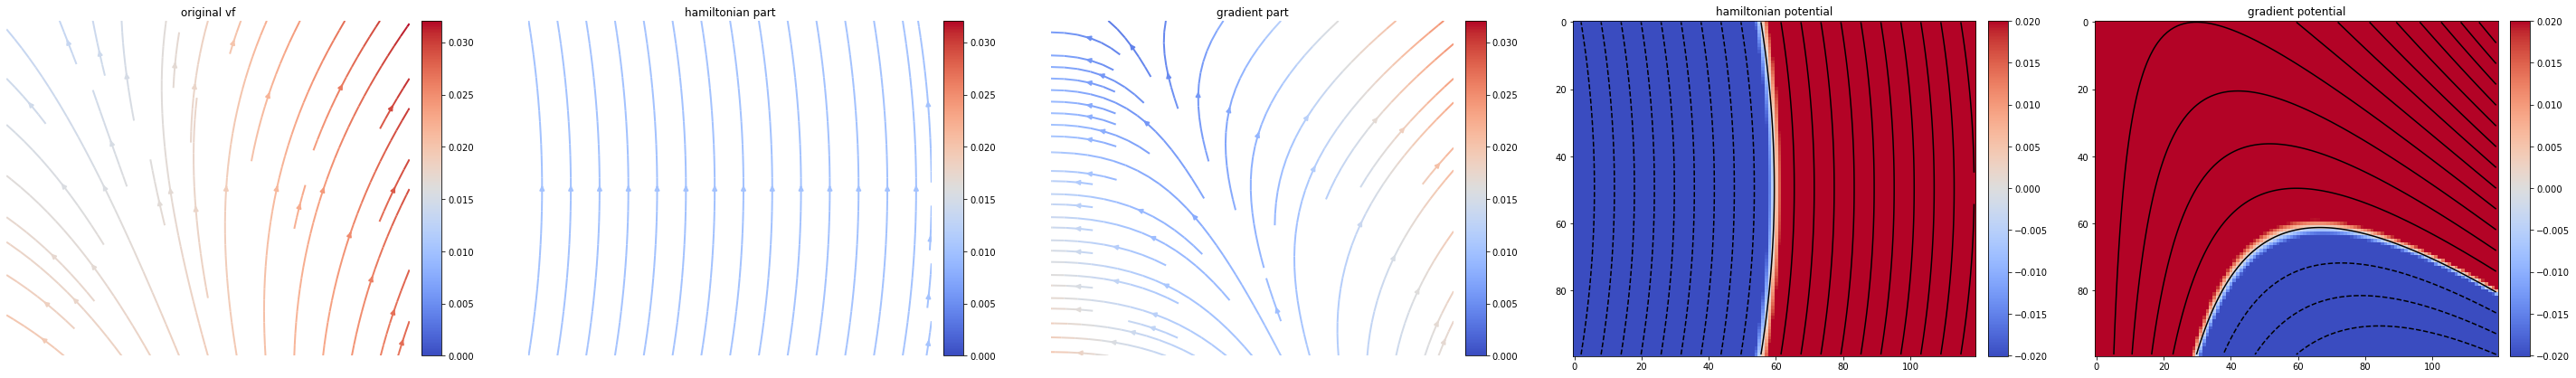

In [16]:
# test with potential field
ny,nx = 100,120  # resolution
M = 2.0  #  the domain will be the square [-M,M]^2
dx = (2.0*M/ny, 2.0*M/nx)
X, Y = np.meshgrid(np.linspace(-M,M,nx),np.linspace(-M,M,ny))

nRu = 10*np.sin(0.03*X)+0.01*Y**2
nRfield = vfield_util.rot_grad(nRu)
#nD = 10*np.sin(0.03*X)+0.01*(100-Y)**2
nD = (X**2 + X*Y + 2*Y + 1)/10
nDfield = vfield_util.grad(nD)
vfield = nRfield+nDfield

mvf = np.linalg.norm(vfield, axis=2)
vrng = (0, mvf.max())

# plot
potential_colour_norm = mpl.colors.Normalize(vmin=min(nRfield.min(),nDfield.min()),vmax=max(nRfield.max(),nDfield.max()))
vf_colour_norm = mpl.colors.Normalize(vmin=0, vmax=mvf.max())

# plot
fig,axs = plt.subplots(1,5,figsize=(50,8))
vfield_vis.plot_slines(vfield[:,:,0],vfield[:,:,1],ax=axs[0],norm=vf_colour_norm,title="original vf")
vfield_vis.plot_slines(nRfield[:,:,0],nRfield[:,:,1],ax=axs[1],norm=vf_colour_norm,title="hamiltonian part")
vfield_vis.plot_slines(nDfield[:,:,0],nDfield[:,:,1],ax=axs[2],norm=vf_colour_norm,title="gradient part")
vfield_vis.plot_contour(nRu,levels=20,ax=axs[3],norm=potential_colour_norm,title="hamiltonian potential")
vfield_vis.plot_contour(nD,levels=20,ax=axs[4],norm=potential_colour_norm,title="gradient potential")

0.0027764909418502254 0.010446802329745238


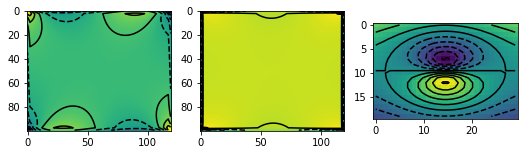

In [18]:
## check harmonicity of the harmonic part
hdiv, hcurl = vfield_util.divcurl(nhhd.h)
print(np.mean(np.abs(hdiv)), np.mean(np.abs(hcurl)))

fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(151)
ax.imshow(hdiv[::-1,:]) 
CS = ax.contour(np.arange(0,hdiv.shape[1]), np.arange(0,hdiv.shape[0]), hdiv[::-1,:], levels=10,colors='k')

ax = fig.add_subplot(152)
ax.imshow(hcurl[::-1,:]) 
CS = ax.contour(np.arange(0,hcurl.shape[1]), np.arange(0,hcurl.shape[0]), hcurl[::-1,:], levels=10,colors='k')

ax = fig.add_subplot(153)
ax.imshow(H[::-1,:]) 
CS = ax.contour(np.arange(0,H.shape[1]), np.arange(0,H.shape[0]), H[::-1,:], levels=10,colors='k')

reconstruction error:  0.0028435121760311817


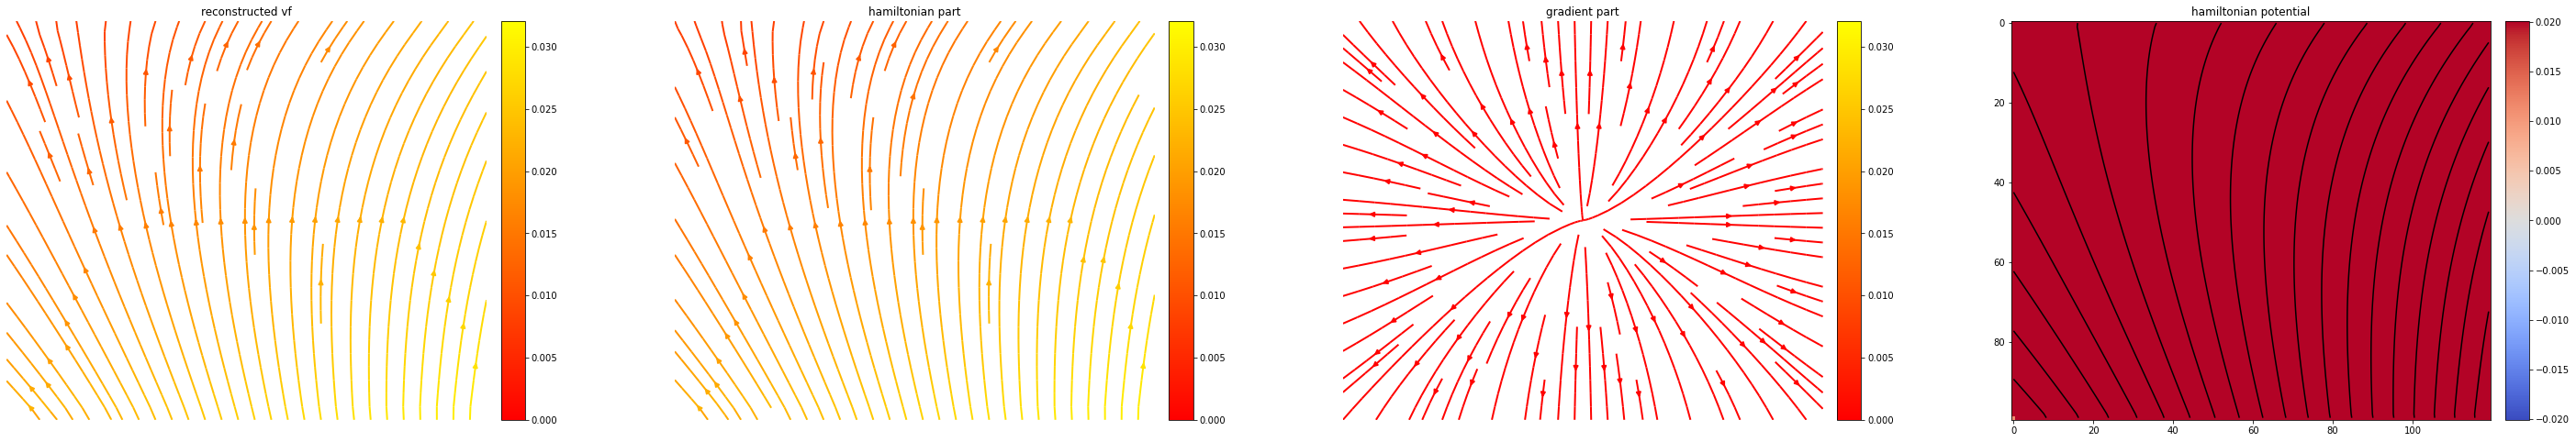

In [48]:
## decomposition and visualisation using nHHD
nhhd = nHHD(grid=(ny,nx), spacings=dx)
nhhd.decompose(vfield)
mr = np.linalg.norm(nhhd.r, axis=2)
md = np.linalg.norm(nhhd.d, axis=2)
mh = np.linalg.norm(nhhd.h, axis=2)

H = vfield_util.integrate2(np.stack((nhhd.h[:,:,1],-nhhd.h[:,:,0]), axis=-1))
nhhd.nRu += H    ##  potential of div-free part
rnRfield = vfield_util.rot_grad(nhhd.nRu)
rnDfield = vfield_util.grad(nhhd.nD)
rvfield = rnRfield + rnDfield
print( "reconstruction error: ", np.mean(np.abs(rvfield-vfield))  )

# reconstructed
fig,axs = plt.subplots(1,4,figsize=(50,8))
vfield_vis.plot_slines(rvfield[:,:,0],rvfield[:,:,1],ax=axs[0],norm=vf_colour_norm,title="reconstructed vf")
vfield_vis.plot_slines(rnRfield[:,:,0],rnRfield[:,:,1],ax=axs[1],norm=vf_colour_norm,title="hamiltonian part")
vfield_vis.plot_slines(rnDfield[:,:,0],rnDfield[:,:,1],ax=axs[2],norm=vf_colour_norm,title="gradient part")
vfield_vis.plot_contour(H,levels=20,ax=axs[3],norm=potential_colour_norm,title="hamiltonian potential")

reconstruction error:  2.505939014814393e-05


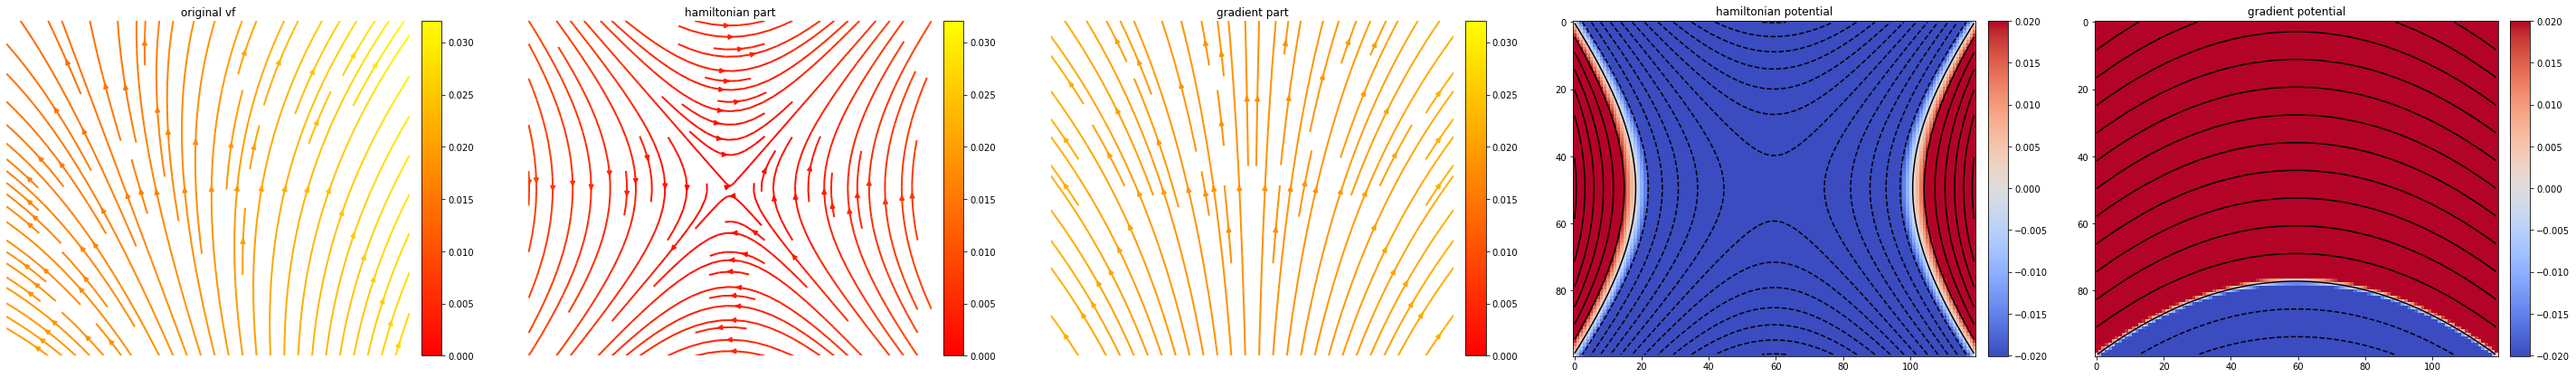

In [49]:
# reconstruction from fft-based decomposition

nrf,ndf,nrp,ndp=vfield_util.decomp(vfield)

ds = vfield_util.grad(ndp)
rs = vfield_util.rot_grad(nrp)
rv = ds+rs

fig,axs = plt.subplots(1,5,figsize=(50,8))
print("reconstruction error: ", np.abs(vfield-rv).mean())
vfield_vis.plot_slines(rv[:,:,0],rv[:,:,1],ax=axs[0],norm=vf_colour_norm,title="original vf")
vfield_vis.plot_slines(rs[:,:,0],rs[:,:,1],ax=axs[1],norm=vf_colour_norm,title="hamiltonian part")
vfield_vis.plot_slines(ds[:,:,0],ds[:,:,1],ax=axs[2],norm=vf_colour_norm,title="gradient part")
vfield_vis.plot_contour(nrp,levels=20,ax=axs[3],norm=potential_colour_norm,title="hamiltonian potential")
vfield_vis.plot_contour(ndp,levels=20,ax=axs[4],norm=potential_colour_norm,title="gradient potential")
